# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Random Forest, and will then apply a Decision Tree classsifier and random forest on the MNIST hand written digits dataset that we already saw.


## Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


**Answer**

**1.**
In the scenario described, the information gain on the first column/attribute will be higher than for other columns/attributes.
So we will choose this column for the first split (i.e. root node):

$Gain(T,X) = Entropy(T) - Entropy(T,X)$

$Entropy(T) = 1.0$

$\{𝐸𝑛𝑡𝑟𝑜𝑝𝑦(𝑇,𝑐𝑖)\}𝑖  = \{0, 0, 1, 1\}$

Following the above, we will get 3 samples in the right subtree:

$((1,1,1),1), ((1,0,0),1), (1,1,0),0)$

Thus, either column/attribute we choose - it won't be possible to classify all the samples correctly, leading to at least one misclassified sample - $error = 0.25$.



**2.**
We can use the 2nd column/attribute as a root node instead. 
Thus the root of the left subtree will split the data on the 1st column/attribute, and the root of the right subtree will split on the 3rd column/attribute.

## Implementing Random Forest From Scratch
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes). 

* Compelete the skeleton class below (hint: you should also create a `DecisionTree` class that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(n)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the bostom dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
  



In [0]:
import math

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import trange

from matplotlib import pyplot as plt
import numpy as np

In [0]:
class TreeNode:
    
    def __init__(self, x, y, indices, min_leaf=5):
        self.x = x 
        self.y = y
        self.indices = indices 
        self.min_leaf = min_leaf
        self.num_rows = len(indices)
        self.num_cols = x.shape[1]
        self.val = np.mean(y[indices])
        self.score = math.inf
        self.__find_split()
        
    def __find_split(self):
        for col in range(self.num_cols): 
            self.__find_better_split(col)
            
        if self.score == math.inf:
            # if reached a leaf
            return
        x = self.x[self.indices, self.col_index]
        left_index = np.nonzero(x <= self.split)[0]
        right_index = np.nonzero(x > self.split)[0]
        self.left_group = TreeNode(self.x, self.y, self.indices[left_index], self.min_leaf)
        self.right_group = TreeNode(self.x, self.y, self.indices[right_index], self.min_leaf)
        
    def __find_better_split(self, col_index):
        x = self.x[self.indices, col_index]
        for row in range(self.num_rows):
            left = x <= x[row]
            right = x > x[row]
            if (right.sum() < self.min_leaf) or \
                (left.sum() < self.min_leaf): 
                continue
            curr_score = self.__find_score(left, right)
            if curr_score < self.score: 
                self.col_index = col_index
                self.score = curr_score
                self.split = x[row]
                
    def __find_score(self, left, right):
        # MSE
        y = self.y[self.indices]
        left_mean = y[left].mean()
        right_mean = y[right].mean()
        return (np.square(y[left] - left_mean).sum() + np.square(y[right] - right_mean).sum()) / len(y)
    
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.score == math.inf:
            # if reached a leaf
            return self.val
        if xi[self.col_index] <= self.split:
             node = self.left_group
        else:
            node = self.right_group
        return node.predict_row(xi)

In [0]:
class DecisionTree:
    
    def __init__(self, min_leaf = 5):
        self.min_leaf = min_leaf
        self.root_node = None
    
    def fit(self, X, y):
        num_samples = len(y)
        all_indices = np.array(np.arange(num_samples))
        self.root_node = TreeNode(X, y, all_indices, self.min_leaf)
    
    def predict(self, X):
        return self.root_node.predict(X)
    
    def predict_single_sample(self, xi):
        return self.root_node.predict_row(xi)

In [0]:
class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_size, min_leaf = 5):
        self.decision_trees = []
        self.X = X
        self.y = y
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.min_leaf = min_leaf
        self.samples_list_to_tree = {}
        self.__init_trees()
    
    def __init_trees(self):
        all_indices = np.arange(self.X.shape[0]).tolist()
        for i in trange(self.n_trees, desc='Trees', leave=True):
            sample_indices = np.random.choice(all_indices, self.sample_size, replace=True)
            current_tree = DecisionTree(self.min_leaf)
            current_tree.fit(self.X[sample_indices], self.y[sample_indices])
            self.decision_trees.append(current_tree)
            sample_indices_key = tuple(sample_indices)
            self.samples_list_to_tree[sample_indices_key] = current_tree
    
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.decision_trees]).sum(axis=0)
        return predictions / len(self.decision_trees)
    
    def oob_mse(self):
        prediction_per_sample = np.zeros(self.X.shape[0])
        for sample_index in range(self.X.shape[0]):
            # collect all trees not containing this sample
            trees_not_containing_sample = []
            for indices_in_tree, tree in self.samples_list_to_tree.items():
                if sample_index not in indices_in_tree:
                    trees_not_containing_sample.append(tree)
            if trees_not_containing_sample:
                prediction_per_sample[sample_index] = np.array([tree.predict_single_sample(self.X[sample_index]) for tree in trees_not_containing_sample]).mean()
        return np.square(self.y - prediction_per_sample).mean()

In [0]:
RANDOM_STATE = 42
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=RANDOM_STATE)
print('The number of samples in the training set %s' % X_train.shape[0])
print('The number of samples in the test set %s' % X_test.shape[0])

The number of samples in the training set 379
The number of samples in the test set 127


In [0]:
tree_ensemble = TreeEnsemble(X_train, y_train, n_trees=200, sample_size=100, min_leaf=2)
y_pred = tree_ensemble.predict(X_test)  # forest is the chosen model

Trees: 100%|██████████| 200/200 [00:50<00:00,  3.96it/s]


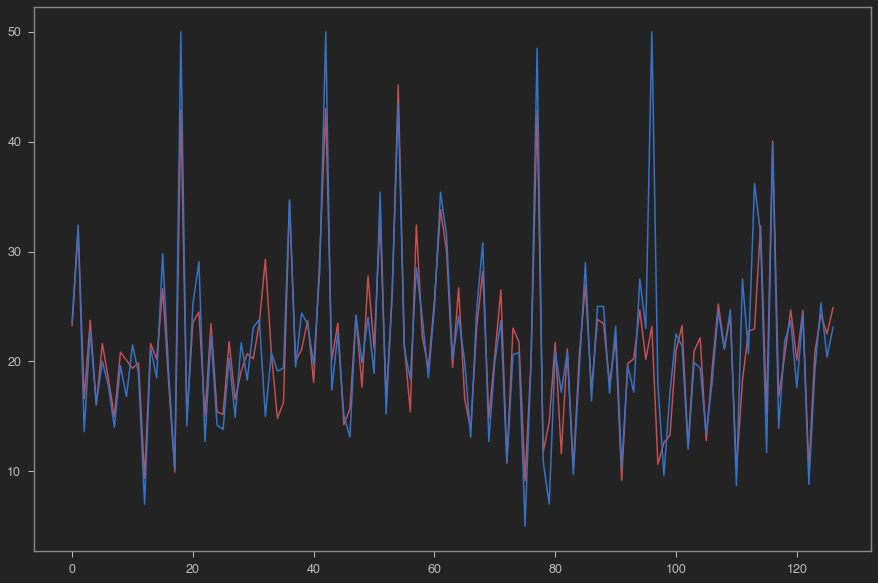

In [0]:
plt.figure(figsize=(15, 10))
lin = np.arange(y_pred.shape[0])
plt.plot(lin, y_pred, color='r')
plt.plot(lin, y_test, color='b')
plt.show()

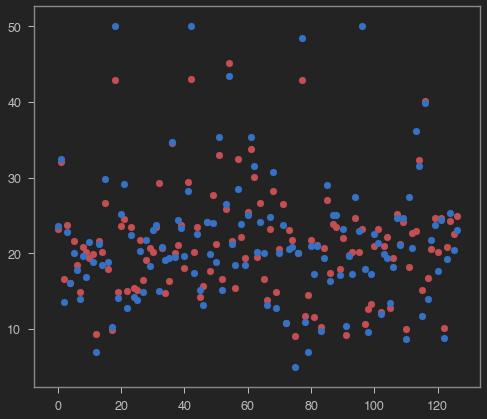

In [0]:
plt.scatter(lin, y_pred, color='r', label='0')
plt.scatter(lin, y_test, color='b', label='1')

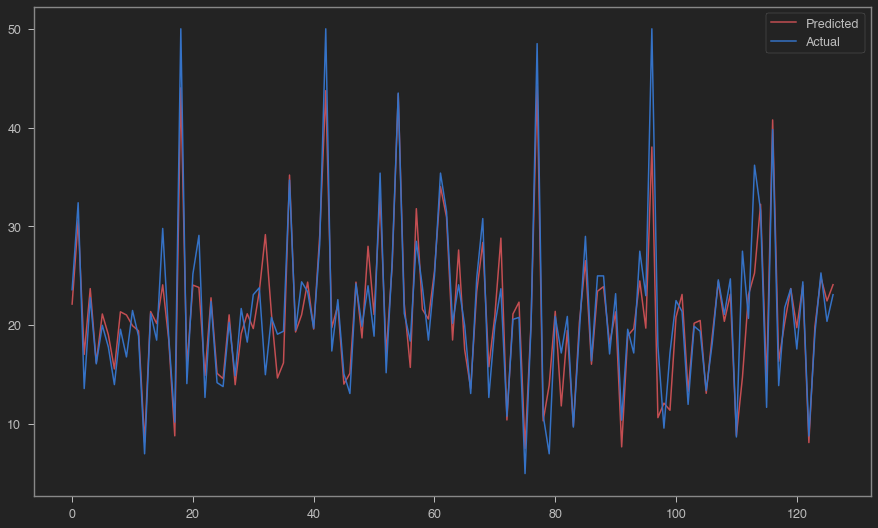

In [0]:
# Comparison to scikit RandomForestRegressor 
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=50, min_samples_leaf=1, max_samples=300, oob_score=True)
regressor.fit(X_train, y_train)
y_scikit_pred = regressor.predict(X_test)
plt.figure(figsize=(15, 9))
lin = np.arange(y_scikit_pred.shape[0])
plt.plot(lin, y_scikit_pred, color='r')
plt.plot(lin, y_test, color='b')
plt.legend(['Predicted', 'Actual'])
plt.show()

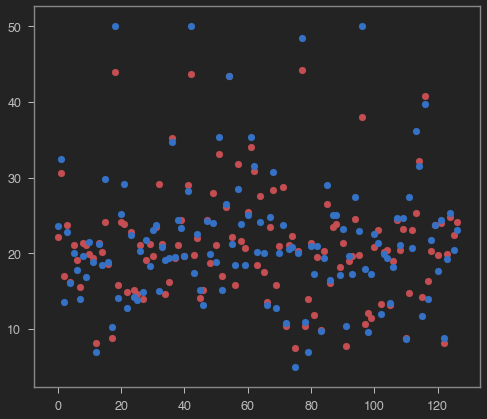

In [0]:
plt.scatter(lin, y_scikit_pred, color='r', label='0')
plt.scatter(lin, y_test, color='b', label='1');

In [0]:
# for n in [1,5,10,20,50,100]:
# for sz in [50,100,300,500]:
# for min_leaf in [1,5]:

# Choosing to skip some of the above values, since the runtime is very long.
# Smaller values for min_leaf gave better results, 
# and also a higher number of trees gave better results as well.
output_list = []
for n in trange(50, 150, 50, desc='num of trees', leave=True):
    for sz in trange(100, 400, 100, desc='sample size', leave=True):
        for min_leaf in trange(1, 4, desc='min_leaf', leave=True):
            forest = TreeEnsemble(X_train, y_train, n, sz, min_leaf)
            mse = forest.oob_mse()
            output_list.append("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
            #print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))

sample size:   0%|          | 0/3 [00:00<?, ?it/s]

min_leaf:   0%|          | 0/3 [00:00<?, ?it/s]


Trees:   0%|          | 0/50 [00:00<?, ?it/s]


Trees:   2%|▏         | 1/50 [00:00<00:24,  2.02it/s]


Trees:   4%|▍         | 2/50 [00:01<00:24,  1.97it/s]


Trees:   6%|▌         | 3/50 [00:01<00:21,  2.18it/s]


Trees:   8%|▊         | 4/50 [00:01<00:19,  2.35it/s]


Trees:  10%|█         | 5/50 [00:02<00:18,  2.44it/s]


Trees:  12%|█▏        | 6/50 [00:02<00:17,  2.57it/s]


Trees:  14%|█▍        | 7/50 [00:02<00:15,  2.71it/s]


Trees:  16%|█▌        | 8/50 [00:03<00:15,  2.69it/s]


Trees:  18%|█▊        | 9/50 [00:03<00:14,  2.73it/s]


Trees:  20%|██        | 10/50 [00:03<00:14,  2.79it/s]


Trees:  22%|██▏       | 11/50 [00:04<00:14,  2.73it/s]


Trees:  24%|██▍       | 12/50 [00:04<00:13,  2.74it/s]


Trees:  26%|██▌       | 13/50 [00:04<00:13,  2.69it/s]


Trees:  28%|██▊       | 14/50 [00:05<00:13,  2.75it/s]


Trees:  30%|███       | 15/50 [00:05<00:12,  2.75it/s]


Tree

Trees:  36%|███▌      | 18/50 [00:04<00:07,  4.19it/s]


Trees:  38%|███▊      | 19/50 [00:04<00:07,  4.33it/s]


Trees:  40%|████      | 20/50 [00:04<00:07,  4.24it/s]


Trees:  42%|████▏     | 21/50 [00:05<00:06,  4.37it/s]


Trees:  44%|████▍     | 22/50 [00:05<00:06,  4.47it/s]


Trees:  46%|████▌     | 23/50 [00:05<00:06,  4.36it/s]


Trees:  48%|████▊     | 24/50 [00:05<00:05,  4.37it/s]


Trees:  50%|█████     | 25/50 [00:05<00:05,  4.35it/s]


Trees:  52%|█████▏    | 26/50 [00:06<00:05,  4.36it/s]


Trees:  54%|█████▍    | 27/50 [00:06<00:05,  4.37it/s]


Trees:  56%|█████▌    | 28/50 [00:06<00:05,  4.35it/s]


Trees:  58%|█████▊    | 29/50 [00:06<00:04,  4.44it/s]


Trees:  60%|██████    | 30/50 [00:07<00:04,  4.46it/s]


Trees:  62%|██████▏   | 31/50 [00:07<00:04,  4.23it/s]


Trees:  64%|██████▍   | 32/50 [00:07<00:04,  3.92it/s]


Trees:  66%|██████▌   | 33/50 [00:07<00:04,  3.76it/s]


Trees:  68%|██████▊   | 34/50 [00:08<00:04,  3.74it/s]


Trees:  70%|███████   | 35/50 [

Trees:  72%|███████▏  | 36/50 [00:22<00:08,  1.63it/s]


Trees:  74%|███████▍  | 37/50 [00:23<00:08,  1.61it/s]


Trees:  76%|███████▌  | 38/50 [00:23<00:07,  1.64it/s]


Trees:  78%|███████▊  | 39/50 [00:24<00:06,  1.62it/s]


Trees:  80%|████████  | 40/50 [00:25<00:06,  1.64it/s]


Trees:  82%|████████▏ | 41/50 [00:25<00:05,  1.62it/s]


Trees:  84%|████████▍ | 42/50 [00:26<00:04,  1.61it/s]


Trees:  86%|████████▌ | 43/50 [00:27<00:04,  1.66it/s]


Trees:  88%|████████▊ | 44/50 [00:27<00:03,  1.66it/s]


Trees:  90%|█████████ | 45/50 [00:28<00:03,  1.62it/s]


Trees:  92%|█████████▏| 46/50 [00:28<00:02,  1.66it/s]


Trees:  94%|█████████▍| 47/50 [00:29<00:01,  1.65it/s]


Trees:  96%|█████████▌| 48/50 [00:30<00:01,  1.63it/s]


Trees:  98%|█████████▊| 49/50 [00:30<00:00,  1.61it/s]


Trees: 100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


min_leaf:  67%|██████▋   | 2/3 [01:12<00:37, 37.77s/it]


Trees:   0%|          | 0/50 [00:00<?, ?it/s]


Trees:   2%|▏         | 1/50 [00:00<00:

Trees:   6%|▌         | 3/50 [00:03<00:49,  1.05s/it]


Trees:   8%|▊         | 4/50 [00:04<00:47,  1.04s/it]


Trees:  10%|█         | 5/50 [00:05<00:47,  1.06s/it]


Trees:  12%|█▏        | 6/50 [00:06<00:45,  1.03s/it]


Trees:  14%|█▍        | 7/50 [00:07<00:43,  1.02s/it]


Trees:  16%|█▌        | 8/50 [00:08<00:41,  1.01it/s]


Trees:  18%|█▊        | 9/50 [00:09<00:41,  1.02s/it]


Trees:  20%|██        | 10/50 [00:10<00:40,  1.00s/it]


Trees:  22%|██▏       | 11/50 [00:11<00:40,  1.03s/it]


Trees:  24%|██▍       | 12/50 [00:12<00:39,  1.03s/it]


Trees:  26%|██▌       | 13/50 [00:13<00:38,  1.05s/it]


Trees:  28%|██▊       | 14/50 [00:14<00:37,  1.03s/it]


Trees:  30%|███       | 15/50 [00:15<00:36,  1.03s/it]


Trees:  32%|███▏      | 16/50 [00:16<00:35,  1.05s/it]


Trees:  34%|███▍      | 17/50 [00:17<00:34,  1.06s/it]


Trees:  36%|███▌      | 18/50 [00:18<00:33,  1.05s/it]


Trees:  38%|███▊      | 19/50 [00:19<00:32,  1.04s/it]


Trees:  40%|████      | 20/50 [00:20<0

Trees:  20%|██        | 20/100 [00:06<00:28,  2.86it/s]


Trees:  21%|██        | 21/100 [00:07<00:28,  2.78it/s]


Trees:  22%|██▏       | 22/100 [00:07<00:29,  2.62it/s]


Trees:  23%|██▎       | 23/100 [00:08<00:30,  2.54it/s]


Trees:  24%|██▍       | 24/100 [00:08<00:30,  2.53it/s]


Trees:  25%|██▌       | 25/100 [00:08<00:28,  2.67it/s]


Trees:  26%|██▌       | 26/100 [00:09<00:26,  2.78it/s]


Trees:  27%|██▋       | 27/100 [00:09<00:26,  2.76it/s]


Trees:  28%|██▊       | 28/100 [00:09<00:25,  2.79it/s]


Trees:  29%|██▉       | 29/100 [00:10<00:24,  2.86it/s]


Trees:  30%|███       | 30/100 [00:10<00:24,  2.85it/s]


Trees:  31%|███       | 31/100 [00:10<00:23,  2.91it/s]


Trees:  32%|███▏      | 32/100 [00:11<00:22,  3.00it/s]


Trees:  33%|███▎      | 33/100 [00:11<00:22,  2.97it/s]


Trees:  34%|███▍      | 34/100 [00:11<00:22,  2.94it/s]


Trees:  35%|███▌      | 35/100 [00:12<00:22,  2.90it/s]


Trees:  36%|███▌      | 36/100 [00:12<00:22,  2.87it/s]


Trees:  37%|██

Trees:  40%|████      | 40/100 [00:10<00:17,  3.49it/s]


Trees:  41%|████      | 41/100 [00:11<00:16,  3.50it/s]


Trees:  42%|████▏     | 42/100 [00:11<00:17,  3.35it/s]


Trees:  43%|████▎     | 43/100 [00:11<00:16,  3.41it/s]


Trees:  44%|████▍     | 44/100 [00:12<00:16,  3.49it/s]


Trees:  45%|████▌     | 45/100 [00:12<00:15,  3.55it/s]


Trees:  46%|████▌     | 46/100 [00:12<00:15,  3.55it/s]


Trees:  47%|████▋     | 47/100 [00:12<00:14,  3.55it/s]


Trees:  48%|████▊     | 48/100 [00:13<00:14,  3.54it/s]


Trees:  49%|████▉     | 49/100 [00:13<00:14,  3.50it/s]


Trees:  50%|█████     | 50/100 [00:13<00:14,  3.48it/s]


Trees:  51%|█████     | 51/100 [00:14<00:14,  3.45it/s]


Trees:  52%|█████▏    | 52/100 [00:14<00:14,  3.42it/s]


Trees:  53%|█████▎    | 53/100 [00:14<00:13,  3.36it/s]


Trees:  54%|█████▍    | 54/100 [00:14<00:13,  3.38it/s]


Trees:  55%|█████▌    | 55/100 [00:15<00:13,  3.44it/s]


Trees:  56%|█████▌    | 56/100 [00:15<00:13,  3.30it/s]


Trees:  57%|██

Trees:  60%|██████    | 60/100 [00:13<00:09,  4.08it/s]


Trees:  61%|██████    | 61/100 [00:14<00:09,  4.20it/s]


Trees:  62%|██████▏   | 62/100 [00:14<00:09,  4.01it/s]


Trees:  63%|██████▎   | 63/100 [00:14<00:09,  3.88it/s]


Trees:  64%|██████▍   | 64/100 [00:14<00:08,  4.03it/s]


Trees:  65%|██████▌   | 65/100 [00:15<00:08,  4.12it/s]


Trees:  66%|██████▌   | 66/100 [00:15<00:08,  4.22it/s]


Trees:  67%|██████▋   | 67/100 [00:15<00:07,  4.27it/s]


Trees:  68%|██████▊   | 68/100 [00:15<00:07,  4.34it/s]


Trees:  69%|██████▉   | 69/100 [00:16<00:07,  4.33it/s]


Trees:  70%|███████   | 70/100 [00:16<00:06,  4.35it/s]


Trees:  71%|███████   | 71/100 [00:16<00:06,  4.27it/s]


Trees:  72%|███████▏  | 72/100 [00:16<00:06,  4.28it/s]


Trees:  73%|███████▎  | 73/100 [00:16<00:06,  4.42it/s]


Trees:  74%|███████▍  | 74/100 [00:17<00:06,  4.11it/s]


Trees:  75%|███████▌  | 75/100 [00:17<00:05,  4.32it/s]


Trees:  76%|███████▌  | 76/100 [00:17<00:05,  4.42it/s]


Trees:  77%|██

Trees:  78%|███████▊  | 78/100 [01:00<00:16,  1.32it/s]


Trees:  79%|███████▉  | 79/100 [01:01<00:16,  1.31it/s]


Trees:  80%|████████  | 80/100 [01:02<00:15,  1.30it/s]


Trees:  81%|████████  | 81/100 [01:03<00:14,  1.32it/s]


Trees:  82%|████████▏ | 82/100 [01:03<00:13,  1.32it/s]


Trees:  83%|████████▎ | 83/100 [01:04<00:12,  1.33it/s]


Trees:  84%|████████▍ | 84/100 [01:05<00:11,  1.34it/s]


Trees:  85%|████████▌ | 85/100 [01:06<00:10,  1.37it/s]


Trees:  86%|████████▌ | 86/100 [01:06<00:10,  1.38it/s]


Trees:  87%|████████▋ | 87/100 [01:07<00:09,  1.35it/s]


Trees:  88%|████████▊ | 88/100 [01:08<00:08,  1.35it/s]


Trees:  89%|████████▉ | 89/100 [01:09<00:08,  1.37it/s]


Trees:  90%|█████████ | 90/100 [01:09<00:07,  1.37it/s]


Trees:  91%|█████████ | 91/100 [01:10<00:06,  1.37it/s]


Trees:  92%|█████████▏| 92/100 [01:11<00:05,  1.39it/s]


Trees:  93%|█████████▎| 93/100 [01:11<00:05,  1.39it/s]


Trees:  94%|█████████▍| 94/100 [01:12<00:04,  1.31it/s]


Trees:  95%|██

Trees:  98%|█████████▊| 98/100 [01:00<00:01,  1.63it/s]


Trees:  99%|█████████▉| 99/100 [01:01<00:00,  1.59it/s]


Trees: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


min_leaf:  67%|██████▋   | 2/3 [02:22<01:14, 74.08s/it]


Trees:   0%|          | 0/100 [00:00<?, ?it/s]


Trees:   1%|          | 1/100 [00:00<00:55,  1.79it/s]


Trees:   2%|▏         | 2/100 [00:01<00:55,  1.76it/s]


Trees:   3%|▎         | 3/100 [00:01<00:57,  1.68it/s]


Trees:   4%|▍         | 4/100 [00:02<00:55,  1.73it/s]


Trees:   5%|▌         | 5/100 [00:02<00:53,  1.78it/s]


Trees:   6%|▌         | 6/100 [00:03<00:52,  1.78it/s]


Trees:   7%|▋         | 7/100 [00:03<00:52,  1.78it/s]


Trees:   8%|▊         | 8/100 [00:04<00:52,  1.74it/s]


Trees:   9%|▉         | 9/100 [00:05<00:49,  1.83it/s]


Trees:  10%|█         | 10/100 [00:05<00:48,  1.84it/s]


Trees:  11%|█         | 11/100 [00:06<00:47,  1.88it/s]


Trees:  12%|█▏        | 12/100 [00:06<00:46,  1.88it/s]


Trees:  13%|█▎        | 13/100 

Trees:  15%|█▌        | 15/100 [00:18<01:44,  1.22s/it]


Trees:  16%|█▌        | 16/100 [00:19<01:40,  1.19s/it]


Trees:  17%|█▋        | 17/100 [00:20<01:37,  1.18s/it]


Trees:  18%|█▊        | 18/100 [00:22<01:37,  1.18s/it]


Trees:  19%|█▉        | 19/100 [00:23<01:37,  1.21s/it]


Trees:  20%|██        | 20/100 [00:24<01:36,  1.20s/it]


Trees:  21%|██        | 21/100 [00:25<01:34,  1.20s/it]


Trees:  22%|██▏       | 22/100 [00:26<01:32,  1.19s/it]


Trees:  23%|██▎       | 23/100 [00:28<01:36,  1.25s/it]


Trees:  24%|██▍       | 24/100 [00:29<01:35,  1.25s/it]


Trees:  25%|██▌       | 25/100 [00:30<01:31,  1.23s/it]


Trees:  26%|██▌       | 26/100 [00:31<01:28,  1.20s/it]


Trees:  27%|██▋       | 27/100 [00:32<01:26,  1.18s/it]


Trees:  28%|██▊       | 28/100 [00:34<01:26,  1.21s/it]


Trees:  29%|██▉       | 29/100 [00:35<01:24,  1.19s/it]


Trees:  30%|███       | 30/100 [00:36<01:21,  1.17s/it]


Trees:  31%|███       | 31/100 [00:37<01:21,  1.19s/it]


Trees:  32%|██

Trees:  35%|███▌      | 35/100 [00:37<01:07,  1.04s/it]


Trees:  36%|███▌      | 36/100 [00:38<01:05,  1.02s/it]


Trees:  37%|███▋      | 37/100 [00:39<01:04,  1.03s/it]


Trees:  38%|███▊      | 38/100 [00:40<01:03,  1.02s/it]


Trees:  39%|███▉      | 39/100 [00:41<01:01,  1.01s/it]


Trees:  40%|████      | 40/100 [00:42<00:59,  1.00it/s]


Trees:  41%|████      | 41/100 [00:43<00:59,  1.01s/it]


Trees:  42%|████▏     | 42/100 [00:44<00:59,  1.03s/it]


Trees:  43%|████▎     | 43/100 [00:45<00:58,  1.03s/it]


Trees:  44%|████▍     | 44/100 [00:46<00:57,  1.03s/it]


Trees:  45%|████▌     | 45/100 [00:47<00:56,  1.03s/it]


Trees:  46%|████▌     | 46/100 [00:48<00:54,  1.01s/it]


Trees:  47%|████▋     | 47/100 [00:49<00:52,  1.01it/s]


Trees:  48%|████▊     | 48/100 [00:50<00:51,  1.00it/s]


Trees:  49%|████▉     | 49/100 [00:51<00:50,  1.01it/s]


Trees:  50%|█████     | 50/100 [00:52<00:49,  1.00it/s]


Trees:  51%|█████     | 51/100 [00:53<00:50,  1.02s/it]


Trees:  52%|██

Trees:  55%|█████▌    | 55/100 [00:50<00:41,  1.10it/s]


Trees:  56%|█████▌    | 56/100 [00:51<00:41,  1.05it/s]


Trees:  57%|█████▋    | 57/100 [00:52<00:39,  1.09it/s]


Trees:  58%|█████▊    | 58/100 [00:53<00:38,  1.08it/s]


Trees:  59%|█████▉    | 59/100 [00:54<00:37,  1.08it/s]


Trees:  60%|██████    | 60/100 [00:54<00:36,  1.09it/s]


Trees:  61%|██████    | 61/100 [00:55<00:35,  1.11it/s]


Trees:  62%|██████▏   | 62/100 [00:56<00:36,  1.05it/s]


Trees:  63%|██████▎   | 63/100 [00:57<00:36,  1.01it/s]


Trees:  64%|██████▍   | 64/100 [00:58<00:35,  1.02it/s]


Trees:  65%|██████▌   | 65/100 [00:59<00:35,  1.01s/it]


Trees:  66%|██████▌   | 66/100 [01:00<00:33,  1.03it/s]


Trees:  67%|██████▋   | 67/100 [01:01<00:31,  1.06it/s]


Trees:  68%|██████▊   | 68/100 [01:02<00:30,  1.05it/s]


Trees:  69%|██████▉   | 69/100 [01:03<00:29,  1.06it/s]


Trees:  70%|███████   | 70/100 [01:04<00:27,  1.07it/s]


Trees:  71%|███████   | 71/100 [01:05<00:26,  1.09it/s]


Trees:  72%|██

In [0]:
for output in output_list:
    print(output)

n_trees:50, sz:100, min_leaf:1 --- oob mse: 15.791029242985559
n_trees:50, sz:100, min_leaf:2 --- oob mse: 17.00286314976763
n_trees:50, sz:100, min_leaf:3 --- oob mse: 17.992281664087095
n_trees:50, sz:200, min_leaf:1 --- oob mse: 16.021229620209834
n_trees:50, sz:200, min_leaf:2 --- oob mse: 15.85909073339482
n_trees:50, sz:200, min_leaf:3 --- oob mse: 15.73112579155128
n_trees:50, sz:300, min_leaf:1 --- oob mse: 15.355465454992682
n_trees:50, sz:300, min_leaf:2 --- oob mse: 15.175914425767171
n_trees:50, sz:300, min_leaf:3 --- oob mse: 15.013759498713924
n_trees:100, sz:100, min_leaf:1 --- oob mse: 15.892027421028997
n_trees:100, sz:100, min_leaf:2 --- oob mse: 16.306911291460054
n_trees:100, sz:100, min_leaf:3 --- oob mse: 16.46986877733741
n_trees:100, sz:200, min_leaf:1 --- oob mse: 14.555932570651713
n_trees:100, sz:200, min_leaf:2 --- oob mse: 15.171753517048055
n_trees:100, sz:200, min_leaf:3 --- oob mse: 15.44733857947365
n_trees:100, sz:300, min_leaf:1 --- oob mse: 13.974992

## Using Decision Tree and Random Forest for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
- Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.
  - You can use `sklearn.tree.DecisionTreeClassifier` and `sklearn.ensemble.RandomForestClassifier`
- Once you are satisfied with the model parameters, plot for each of the models (a single decision tree and random forest) the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

In [4]:
from sklearn.datasets import load_digits

digits = load_digits()

def display_digit(d, img):
  img = img.reshape(8, 8)
  plt.subplot(1, 10, d + 1)
  plt.title('%s' % d)
  plt.imshow(img, cmap=plt.cm.binary)

# Plot the original data
plt.figure(figsize=(27, 3))
for i in range(10):
    display_digit(i, digits.data[i])
plt.show()

# Plot as only black and white - remove grey values
bw_digits = np.array(digits.data)
bw_digits[bw_digits < 8.0] = 0
bw_digits[bw_digits >= 8.0] = 16

plt.figure(figsize=(27, 3))
for i in range(10):
    display_digit(i, bw_digits[i])
plt.show()

NameError: ignored

Seems that using only black and white (darkest and lightest) pixels won't be better than the origianl grayscale values - the transition to black and white distorts the digits and makes them ambiguous, for example digit 5 displayed above.
So we'll consider other hyperparameters, keeping in mind that decision trees tend to overfit the data.


* **Use minimum samples for a node split**: used against overfitting. Still, extreme high values can cause underfitting - so we will tune them with Cross Validation.
    
* **Use minimum samples for a leaf**: used against overfitting, same as previous hyperparameter. 
Used to control over-fitting similar to min_samples_split. Usually it's better to choose low values for imbalanced class problems, since the regions in which the minority class will be in majority will be very small.

* **maximum depth of tree**: used against overfitting, as the higher depth of a tree allows the model to learn relations very specific to a particular sample. Should also be tuned with Cross Validation.

* **Maximum number of leaves**:  Can replace the previous hyperparameter. Since the trees created will be binary trees, a depth of N will produce 2N leaves.

* **Maximum features to consider for split**: The number of features to consider when looking for a best split, randomly chosen. Usually, a good value to use will be the square root of the total number of features, but we can also check till about a third of the total number of features. Higher values can lead to overfitting - depending on the data.

We will use Gini for Random Forest, as it is less computationally intensive than Entropy, and provides usually similar results.
As for Decision Tree - Entropy yields better results.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X_digits_train, X_digits_test, y_digits_train, y_digits_test = train_test_split(digits.data, digits.target, random_state=42)
print('The number of training samples %s, features %s' % (X_digits_train.shape[0], X_digits_train.shape[1]))

The number of training samples 1347, features 64


In [7]:
# Random Forest hyperparameters exploration
min_samples_split = [0.01, 0.1, 0.3]
min_samples_leaf = [1, 2, 3]
for i in trange(450, 600, 50): # estimators
    for j in min_samples_split:
        for k in min_samples_leaf:
            classifier = RandomForestClassifier(n_estimators=i, 
                                                min_samples_leaf=k, 
                                                min_samples_split=j, 
                                                criterion='gini', 
                                                oob_score=True, 
                                                random_state=42)
            classifier.fit(X_digits_train, y_digits_train)
            print('(%s,%s,%s) Cross-validation score %.5f, out-of-bag score %.5f' % 
                (i, j, k, cross_val_score(classifier, X_digits_test, y_digits_test).mean(), classifier.oob_score_))

  0%|          | 0/3 [00:00<?, ?it/s]

(450,0.01,1) Cross-validation score 0.95111, out-of-bag score 0.96585
(450,0.01,2) Cross-validation score 0.95556, out-of-bag score 0.96511
(450,0.01,3) Cross-validation score 0.94667, out-of-bag score 0.96288
(450,0.1,1) Cross-validation score 0.90000, out-of-bag score 0.89013
(450,0.1,2) Cross-validation score 0.90000, out-of-bag score 0.89013
(450,0.1,3) Cross-validation score 0.90000, out-of-bag score 0.89013
(450,0.3,1) Cross-validation score 0.77556, out-of-bag score 0.76318
(450,0.3,2) Cross-validation score 0.77556, out-of-bag score 0.76318


 33%|███▎      | 1/3 [00:55<01:51, 55.69s/it]

(450,0.3,3) Cross-validation score 0.77556, out-of-bag score 0.76318
(500,0.01,1) Cross-validation score 0.95333, out-of-bag score 0.96585
(500,0.01,2) Cross-validation score 0.95333, out-of-bag score 0.96585
(500,0.01,3) Cross-validation score 0.94889, out-of-bag score 0.96437
(500,0.1,1) Cross-validation score 0.89778, out-of-bag score 0.89384
(500,0.1,2) Cross-validation score 0.90000, out-of-bag score 0.89384
(500,0.1,3) Cross-validation score 0.90000, out-of-bag score 0.89458
(500,0.3,1) Cross-validation score 0.78444, out-of-bag score 0.76689
(500,0.3,2) Cross-validation score 0.78444, out-of-bag score 0.76689


 67%|██████▋   | 2/3 [01:56<00:57, 57.28s/it]

(500,0.3,3) Cross-validation score 0.78444, out-of-bag score 0.76689
(550,0.01,1) Cross-validation score 0.95333, out-of-bag score 0.96585
(550,0.01,2) Cross-validation score 0.95333, out-of-bag score 0.96808
(550,0.01,3) Cross-validation score 0.95111, out-of-bag score 0.96511
(550,0.1,1) Cross-validation score 0.90000, out-of-bag score 0.89384
(550,0.1,2) Cross-validation score 0.90000, out-of-bag score 0.89384
(550,0.1,3) Cross-validation score 0.90000, out-of-bag score 0.89384
(550,0.3,1) Cross-validation score 0.78444, out-of-bag score 0.77209
(550,0.3,2) Cross-validation score 0.78444, out-of-bag score 0.77209


100%|██████████| 3/3 [03:03<00:00, 60.13s/it]

(550,0.3,3) Cross-validation score 0.78444, out-of-bag score 0.77209


In [8]:
# Judging from the above results, choosing the following - 
# (550,0.01,2) Cross-validation score 0.95333, out-of-bag score 0.96808
final_random_forest_classifier = RandomForestClassifier(n_estimators=550, 
                                                         min_samples_leaf=2, 
                                                         min_samples_split=0.01, 
                                                         criterion='gini', 
                                                         oob_score=True, 
                                                         random_state=42)
final_random_forest_classifier.fit(X_digits_train, y_digits_train)
print('Cross-validation score %.5f, out-of-bag score %.5f'
      % (cross_val_score(final_random_forest_classifier, 
                         X_digits_test, y_digits_test).mean(), 
         final_random_forest_classifier.oob_score_))


Cross-validation score 0.95333, out-of-bag score 0.96808


In [9]:
# Decision Tree hyperparameters exploration
min_samples_split = [0.01, 0.1, 0.3]
min_samples_leaf = [1, 2, 3]
for j in min_samples_split:
    for k in min_samples_leaf:
        decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', 
                                                          min_samples_leaf=k, 
                                                          min_samples_split=j, 
                                                          random_state=42)
        decision_tree_classifier.fit(X_digits_train, y_digits_train)
        print('(%s,%s) Cross-validation score %.5f' % 
              (j, k, cross_val_score(decision_tree_classifier, X_digits_test, y_digits_test).mean()))

(0.01,1) Cross-validation score 0.78000
(0.01,2) Cross-validation score 0.78889
(0.01,3) Cross-validation score 0.78222
(0.1,1) Cross-validation score 0.73556
(0.1,2) Cross-validation score 0.73556
(0.1,3) Cross-validation score 0.73556
(0.3,1) Cross-validation score 0.44444
(0.3,2) Cross-validation score 0.44444
(0.3,3) Cross-validation score 0.44444


In [10]:
# Judging from the above results, choosing:
# (0.01,2) Cross-validation score 0.78889
final_decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', 
                                                        min_samples_leaf=2, 
                                                        min_samples_split=0.01, 
                                                        random_state=42)
final_decision_tree_classifier.fit(X_digits_train, y_digits_train)
print('Cross-validation score %.5f' % 
      (cross_val_score(final_decision_tree_classifier, X_digits_test, y_digits_test).mean()))


Cross-validation score 0.78889


**Plots:**

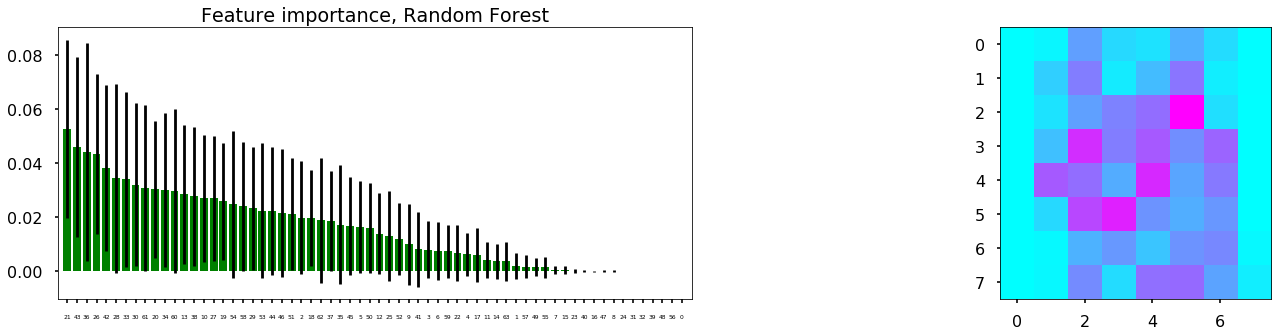

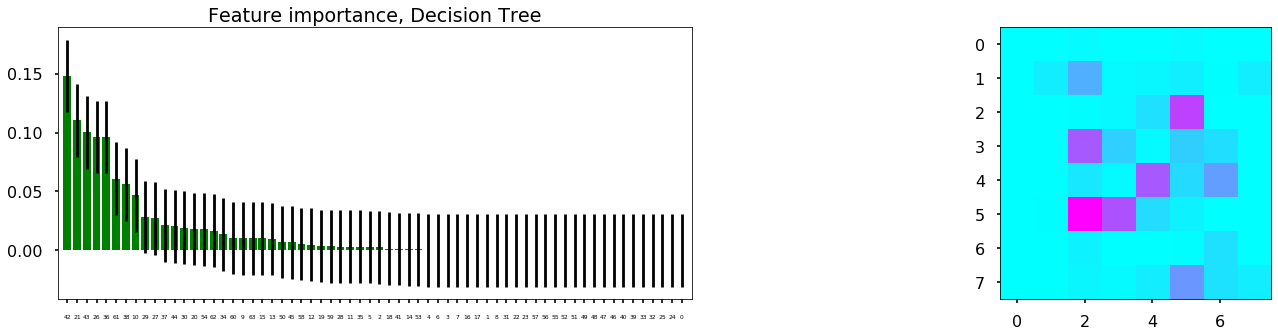

In [21]:
plt.style.use('seaborn-poster')
def plot_classifier_importances(classifier, model_name, X):
    feature_importances = classifier.feature_importances_
    std = None
    if isinstance (classifier, DecisionTreeClassifier):
        std = np.std(classifier.feature_importances_, axis=0)
    else: # it's a forest
        std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
    importances_indices = np.argsort(classifier.feature_importances_)[::-1]

    plt.figure(figsize=(25, 5))
    plt.subplot(1, 2, 1)
    plt.title('Feature importance, %s' % model_name)
    if isinstance (classifier, DecisionTreeClassifier):
        plt.bar(range(X.shape[1]), 
                feature_importances[importances_indices], 
                color="green", 
                yerr=std, 
                align="center")
    else:
        plt.bar(range(X.shape[1]), 
                feature_importances[importances_indices], 
                color="green", 
                yerr=std[importances_indices], 
                align="center")
    plt.xticks(range(X.shape[1]), importances_indices, fontsize = 6)
    plt.xlim([-1, X.shape[1]])

    plt.subplot(1, 2, 2)
    img = feature_importances.reshape(8, 8)
    plt.imshow(img, cmap=plt.cm.cool)
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.show()

plot_classifier_importances(final_random_forest_classifier, 'Random Forest', X_digits_train)
plot_classifier_importances(final_decision_tree_classifier, 'Decision Tree', X_digits_train)


In [19]:
# Random forest 
print("__==--Random Forest: Class Assignment Probs--==__")
y_digits_pred = final_random_forest_classifier.predict(X_digits_test)

y_digits_pred_proba = final_random_forest_classifier.predict_proba(
    X_digits_test[y_digits_test == y_digits_pred]).max(axis=0)
print('Correctly classified examples: min %.2f, max %.2f, mean %.2f' % 
      (y_digits_pred_proba.min(),
       y_digits_pred_proba.max(), 
       y_digits_pred_proba.mean()))

y_digits_pred_missclassified_proba = final_random_forest_classifier.predict_proba(
    X_digits_test[y_digits_test != y_digits_pred]).max(axis=0)
print('Misclassified examples: min %.2f, max %.2f, mean %.2f' % 
      (y_digits_pred_missclassified_proba.min(), 
       y_digits_pred_missclassified_proba.max(), 
       y_digits_pred_missclassified_proba.mean()))

# Decision tree
print("__==--Decision Tree: Class Assignment Probs--==__")
y_digits_pred = final_decision_tree_classifier.predict(X_digits_test)

y_digits_pred_proba = final_decision_tree_classifier.predict_proba(
    X_digits_test[y_digits_test == y_digits_pred]).max(axis=0)
print('Correctly classified examples: min %.2f, max %.2f, mean %.2f' % 
      (y_digits_pred_proba.min(), 
       y_digits_pred_proba.max(), 
       y_digits_pred_proba.mean()))

y_digits_pred_missclassified_proba = final_decision_tree_classifier.predict_proba(
    X_digits_test[y_digits_test != y_digits_pred]).max(axis=0)
print('Misclassified examples: min %.2f, max %.2f, mean %.2f' % 
      (y_digits_pred_missclassified_proba.min(), 
       y_digits_pred_missclassified_proba.max(), 
       y_digits_pred_missclassified_proba.mean()))

__==--Random Forest: Class Assignment Probs--==__
Correctly classified examples: min 0.77, max 1.00, mean 0.94
Misclassified examples: min 0.20, max 0.44, mean 0.34
__==--Decision Tree: Class Assignment Probs--==__
Correctly classified examples: min 1.00, max 1.00, mean 1.00
Misclassified examples: min 0.50, max 1.00, mean 0.90


Misclassified samples have on average lower probabilities than correctly classified:

Classifier | Misclassified | Correctly Classified
-------- | -------- | -------
Random Forest   | 0.34   | 0.94
Decision Tree   | 0.9    | 1.0

However, some misclassified samples have 1.0 probability - which can be due to overfitting.

## References
- https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/